# Verkennen

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

def missing(df):
    return df[df.isna().any(axis='columns')]

def movie_url(imdb_id):
    return f'https://www.imdb.com/title/tt{imdb_id:07}/'

def user_url(twitter_id):
    return f'https://twitter.com/i/user/{twitter_id}'

In [2]:
movies = pd.read_parquet('data/movies_clean.parquet')
print(f'n_movies = {movies.shape[0]}')
movies.head()

n_movies = 35611


,imdb_id,title,year,genres
0,8,Edison Kinetoscopic Record of a Sneeze,1894,"[documentary, short]"
1,10,La sortie des usines Lumière,1895,"[documentary, short]"
2,12,The Arrival of a Train,1896,"[documentary, short]"
3,25,The Oxford and Cambridge University Boat Race,1895,None
4,91,Le manoir du diable,1896,"[short, horror]"


In [3]:
ratings = pd.read_parquet('data/ratings_clean.parquet')
print(f'n_ratings = {ratings.shape[0]}')
ratings.head()

n_ratings = 857465


,user_id,imdb_id,rating,date_time
0,1,114508,8,2013-10-05 21:00:50
1,2,208092,5,2020-04-09 21:01:12
2,2,358273,9,2020-01-15 03:10:27
3,2,10039344,5,2020-01-09 20:50:53
4,2,6199572,3,2020-05-14 18:54:43


In [4]:
users = pd.read_parquet('data/users_clean.parquet')
print(f'n_users = {users.shape[0]}')
users.head()

n_users = 62798


,user_id,twitter_id
0,1,139564917
1,2,522540374
2,3,475571186
3,4,215022153
4,5,349681331


## Movies

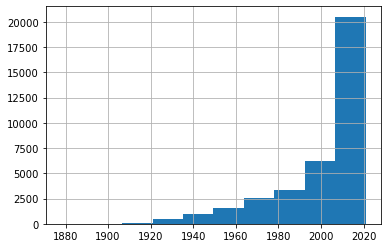

In [5]:
movies['year'].hist();

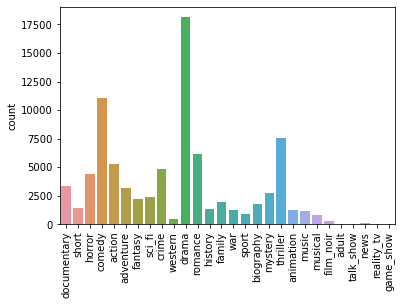

In [6]:
ax = sns.countplot(np.concatenate(movies['genres'].dropna().values))
ax.set_xticklabels(ax.get_xticklabels(), rotation='90');

## Ratings

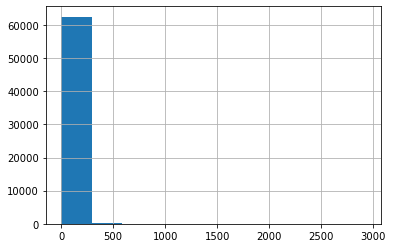

In [7]:
ratings_user = ratings.groupby('user_id')['rating'].count()
ratings_user.hist();

In [8]:
ratings_user.describe()

count    62798.000000
mean        13.654336
std         48.884962
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max       2926.000000
Name: rating, dtype: float64

In [9]:
active_users = (
    pd.DataFrame(ratings_user)
        .merge(users, 'left', 'user_id')
        .drop(columns='user_id')
        .sort_values('rating', ascending=False)
)
active_users = (
    active_users
        .drop(columns='twitter_id')
        .join(active_users['twitter_id'].apply(user_url))
)
active_users = active_users[['twitter_id', 'rating']]
active_users.columns = ['user_url', 'n_ratings']
active_users.head()

,user_url,n_ratings
23252,https://twitter.com/i/user/229985772,2926
12738,https://twitter.com/i/user/22832104,2075
36921,https://twitter.com/i/user/363853315,2058
46669,https://twitter.com/i/user/43349934,1858
61281,https://twitter.com/i/user/101459318,1606


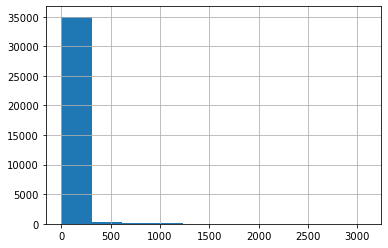

In [10]:
ratings_movie = ratings.groupby('imdb_id')['rating'].count()
ratings_movie.hist();

In [11]:
ratings_movie.describe()

count    35611.000000
mean        24.078655
std        111.876631
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       3086.000000
Name: rating, dtype: float64

In [12]:
active_movies = (
    pd.DataFrame(ratings_movie)
        .merge(movies[['imdb_id', 'title']], 'left', 'imdb_id')
        .sort_values('rating', ascending=False)
)
active_movies = (
    active_movies
        .drop(columns='imdb_id')
        .join(active_movies['imdb_id'].apply(movie_url))
)
active_movies = active_movies[['title', 'imdb_id', 'rating']]
active_movies.columns= ['title', 'movie_url', 'n_ratings']
active_movies.head()

,title,movie_url,n_ratings
18684,Gravity,https://www.imdb.com/title/tt1454468/,3086
15592,Interstellar,https://www.imdb.com/title/tt0816692/,2851
16299,The Wolf of Wall Street,https://www.imdb.com/title/tt0993846/,2787
15292,Man of Steel,https://www.imdb.com/title/tt0770828/,2670
33748,Joker,https://www.imdb.com/title/tt7286456/,2595


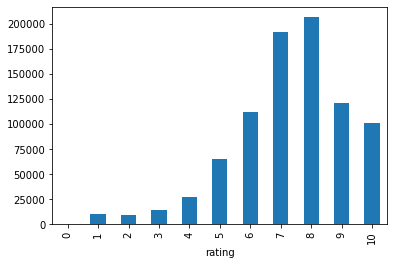

In [13]:
rating_counts = ratings.groupby('rating')['user_id'].count()
rating_counts.plot.bar();

In [14]:
rating_balance = rating_counts / len(ratings)
rating_balance

rating
0     0.000302
1     0.011805
2     0.010080
3     0.016897
4     0.030934
5     0.075201
6     0.130719
7     0.224014
8     0.241113
9     0.141279
10    0.117656
Name: user_id, dtype: float64

In [15]:
rating_balance.cumsum()

rating
0     0.000302
1     0.012107
2     0.022186
3     0.039084
4     0.070018
5     0.145219
6     0.275938
7     0.499952
8     0.741065
9     0.882344
10    1.000000
Name: user_id, dtype: float64

In [16]:
ratings['rating'].describe()

count    857465.000000
mean          7.311786
std           1.854717
min           0.000000
25%           6.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64

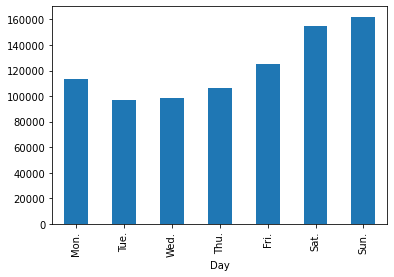

In [17]:
ax = ratings.groupby(ratings['date_time'].dt.dayofweek)['rating'].count().plot.bar()
ax.set_xticklabels(['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
ax.set_xlabel('Day');

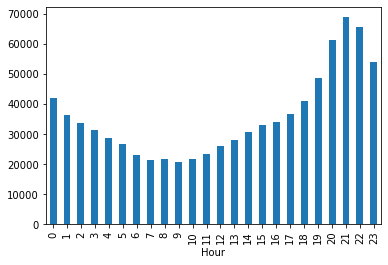

In [18]:
ax = ratings.groupby(ratings['date_time'].dt.hour)['rating'].count().plot.bar()
ax.set_xlabel('Hour');

In [19]:
top_movies = (
    pd
        .DataFrame(ratings.groupby('imdb_id')['rating'].mean())
        .join(ratings.groupby('imdb_id')['rating'].count(),lsuffix='_mean', rsuffix='_count')
        .merge(movies, 'left', 'imdb_id')
        .sort_values(['rating_mean', 'rating_count'], ascending=False)
)
top_movies = (
    top_movies
        .drop(columns='imdb_id')
        .join(top_movies['imdb_id'].apply(movie_url))
)
top_movies = top_movies[['title', 'year', 'genres', 'imdb_id', 'rating_mean', 'rating_count']]
top_movies.columns = ['title', 'year', 'genres', 'movie_url', 'mean_rating', 'n_ratings']
top_movies.head(10)

,title,year,genres,movie_url,mean_rating,n_ratings
30422,MSG 2 the Messenger,2015,"[comedy, drama, fantasy, horror]",https://www.imdb.com/title/tt4921860/,10.0,48
31092,Avengers: Age of Ultron Parody,2015,"[short, comedy]",https://www.imdb.com/title/tt5262972/,10.0,28
33132,Five Minutes,2017,"[short, comedy]",https://www.imdb.com/title/tt6662050/,10.0,22
25234,Selam,2013,"[drama, romance]",https://www.imdb.com/title/tt2737018/,10.0,10
31935,Let There Be Light,2017,[drama],https://www.imdb.com/title/tt5804314/,10.0,7
22994,Crawl Bitch Crawl,2012,"[horror, sci_fi, thriller]",https://www.imdb.com/title/tt2219210/,10.0,6
24749,"Quiet Riot: Well Now You're Here, There's No W...",2014,"[documentary, music]",https://www.imdb.com/title/tt2560840/,10.0,6
18559,Romeo Juliet,2009,[drama],https://www.imdb.com/title/tt1431149/,10.0,5
22046,Third Contact,2011,"[drama, mystery, sci_fi, thriller]",https://www.imdb.com/title/tt2059318/,10.0,5
29574,Make Like a Dog,2015,"[short, comedy, drama]",https://www.imdb.com/title/tt4448444/,10.0,5


In [20]:
top_movies[top_movies['n_ratings'] >= 1000].sort_values('mean_rating', ascending=False).head(10)

,title,year,genres,movie_url,mean_rating,n_ratings
8607,The Shawshank Redemption,1994,[drama],https://www.imdb.com/title/tt0111161/,9.404695,1065
33748,Joker,2019,"[crime, drama, thriller]",https://www.imdb.com/title/tt7286456/,9.124855,2595
29015,Avengers: Endgame,2019,"[action, adventure, fantasy, sci_fi]",https://www.imdb.com/title/tt4154796/,9.043665,1397
15592,Interstellar,2014,"[adventure, drama, sci_fi]",https://www.imdb.com/title/tt0816692/,8.829884,2851
29014,Avengers: Infinity War,2018,"[action, adventure, sci_fi]",https://www.imdb.com/title/tt4154756/,8.764346,1307
22457,Hacksaw Ridge,2016,"[biography, drama, history, war]",https://www.imdb.com/title/tt2119532/,8.710291,1681
24829,Whiplash,2014,"[drama, music]",https://www.imdb.com/title/tt2582802/,8.630022,1792
34692,1917,2019,"[drama, war]",https://www.imdb.com/title/tt8579674/,8.606120,1536
21125,Django Unchained,2012,"[drama, western]",https://www.imdb.com/title/tt1853728/,8.590600,1617
33221,Gisaengchung,2019,[drama],https://www.imdb.com/title/tt6751668/,8.547860,1285


In [21]:
top_movies[top_movies['n_ratings'] >= 1000].sort_values('mean_rating').head(10)

,title,year,genres,movie_url,mean_rating,n_ratings
21590,The Hangover Part III,2013,"[adventure, comedy, crime]",https://www.imdb.com/title/tt1951261/,6.081818,1100
25549,Lucy,2014,"[action, sci_fi, thriller]",https://www.imdb.com/title/tt2872732/,6.507125,1193
18319,Suicide Squad,2016,"[action, adventure, fantasy, sci_fi]",https://www.imdb.com/title/tt1386697/,6.564557,1580
15667,Godzilla,2014,"[action, adventure, sci_fi, thriller]",https://www.imdb.com/title/tt0831387/,6.669903,1442
25856,Batman v Superman: Dawn of Justice,2016,"[action, adventure, fantasy, sci_fi]",https://www.imdb.com/title/tt2975590/,6.824848,1650
18549,The Wolverine,2013,"[action, adventure, sci_fi]",https://www.imdb.com/title/tt1430132/,6.856841,1418
18366,It,2017,"[horror, thriller]",https://www.imdb.com/title/tt1396484/,6.858114,1177
19125,Elysium,2013,"[action, drama, sci_fi]",https://www.imdb.com/title/tt1535108/,6.920126,1590
17625,This Is the End,2013,"[comedy, fantasy]",https://www.imdb.com/title/tt1245492/,6.977344,1280
18819,Oblivion,2013,"[action, adventure, sci_fi]",https://www.imdb.com/title/tt1483013/,7.010017,1797


In [22]:
top_movies[top_movies['n_ratings'] >= 100].sort_values('mean_rating').head(10)

,title,year,genres,movie_url,mean_rating,n_ratings
9730,The Thin Red Line,1998,"[drama, war]",https://www.imdb.com/title/tt0120863/,3.542969,256
15420,Scary Movie 5,2013,[comedy],https://www.imdb.com/title/tt0795461/,3.808081,198
3599,Where Eagles Dare,1968,"[action, adventure, war]",https://www.imdb.com/title/tt0065207/,4.225490,102
18083,Movie 43,2013,[comedy],https://www.imdb.com/title/tt1333125/,4.267782,239
23553,50 tinten grijs,2015,"[drama, romance, thriller]",https://www.imdb.com/title/tt2322441/,4.420323,433
17593,Death Note,2017,"[adventure, crime, drama, fantasy, horror, mys...",https://www.imdb.com/title/tt1241317/,4.440000,275
16542,The Legend of Hercules,2014,"[action, adventure, fantasy]",https://www.imdb.com/title/tt1043726/,4.504673,214
15192,Rings,2017,"[drama, horror, mystery, romance, thriller]",https://www.imdb.com/title/tt0498381/,4.525862,116
18910,Fantastic Four,2015,"[action, adventure, drama, sci_fi]",https://www.imdb.com/title/tt1502712/,4.535135,370
19548,Zoolander 2,2016,[comedy],https://www.imdb.com/title/tt1608290/,4.560241,166


# Conclusies
35611 films, 857465 beoordelingen en 62798 gebruikers.

## Ratings
De gemiddelde gebruiker beoordeeld weinig films ($ \overline{x} $ = 13,65, s = 48,88 en mediaan = 2). De gemiddelde film wordt weinig beoordeeld ($ \overline{x} $ = 24,08, s = 111,88 en mediaan = 2). Voor beide zijn uitschieters geen anomalieën. Beoordelingen zijn hoofdzakelijk positief ($ \overline{x} $ = 7,31, s = 1,85 en mediaan = 8). Kolom `date_time` is vermoedelijk seconden sinds Unix epoch, lokale tijd.